# Olympian's Path to the Podium

In [1]:
import xlrd
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# 1. Data Set Description

* **df** = a dataset of athletes from each Olympic game where each row represents an athlete who has competed in the Olympics since 1896.

## Column Definition

<ol>
<li> ID - An ID that corresponds to each individual athlete. (i.e. One athlete per many Olympic events) <li>
Name - Name of an athlete. <li>
Sex - Identifies an athlete as male or female. <li>
Age - Age of the athlete. <li>
Height - Height of the athlete. <li>
Weight - Weight of the athlete. <li>
NOC - Country of Nationality. <li>
Year - Year that the Olympic was held. <li>
Season - Designates Summer or Winter Olympics. <li>
City - City where the Olympics was held. <li>
Sport - Sport in which the athlete competed. <li>
Medal - An athlete can win gold, silver, bronze, or NaN resulting in not placing on the podium. <li>
Event - Event of a particular sport. One sport can have many events.

In [2]:
df = pd.read_csv('athlete_events.csv')
df.head(3)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN


# 2. Data Cleaning

#### Drop columns where the information is unnecessary.

* **Team**: Repetitive information since their team name is normally the country the athletes are representing.
* **Games**: Repetitive information also listed separately in the 'Year' and 'Season' column.

In [3]:
df = df.drop(columns = ['Team', 'Games'])
df.head(3)

,ID,Name,Sex,Age,Height,Weight,NOC,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920,Summer,Antwerpen,Football,Football Men's Football,NaN


#### Remove repetitive information from the 'Events' column to limit the description due to it being said in the 'Sex' and 'Sport' columns.

* Drop the original 'Event' column
* Rename our 'Events' column to 'Event'

In [4]:
df['Events'] = df['Event'].apply(lambda x: x.split('\'s ')).str[1]

In [5]:
df.drop(inplace = True, columns = 'Event')
df.rename(inplace = True, columns = {'Events':'Event'})
df.head(3)

,ID,Name,Sex,Age,Height,Weight,NOC,Year,Season,City,Sport,Medal,Event
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992,Summer,Barcelona,Basketball,NaN,Basketball
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012,Summer,London,Judo,NaN,Extra-Lightweight
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920,Summer,Antwerpen,Football,NaN,Football


#### Convert 'Season' to binary values

* **Winter** = 0
* **Summer** = 1

In [6]:
df['Seasons'] = df.Season.apply(lambda x:0 if x == 'Winter' else 1)
df.drop(inplace = True, columns = 'Season')
df.rename(inplace = True, columns = {'Seasons':'Season'})
df.head(3)

,ID,Name,Sex,Age,Height,Weight,NOC,Year,City,Sport,Medal,Event,Season
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992,Barcelona,Basketball,NaN,Basketball,1
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012,London,Judo,NaN,Extra-Lightweight,1
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920,Antwerpen,Football,NaN,Football,1


#### Convert Medals to binary values
* **No Medal** = 0
* **Gold or Silver or Bronze** = 1

In [7]:
df['Medals'] = df.Medal.apply(lambda x: 1 if x == 'Gold' or x == 'Silver' or x == 'Bronze'  else 0)

#### Convert Sex to binary values

* **Male** = 0
* **Female** = 1

In [8]:
df['Gender'] = df.Sex.apply(lambda x: 0 if x == 'M' else 1)
df.head(3)

,ID,Name,Sex,Age,Height,Weight,NOC,Year,City,Sport,Medal,Event,Season,Medals,Gender
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992,Barcelona,Basketball,NaN,Basketball,1,0,0
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012,London,Judo,NaN,Extra-Lightweight,1,0,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920,Antwerpen,Football,NaN,Football,1,0,0


#### Drop original 'Sex' and 'Medal' columns
* Replace all 'NaN' (null values) with 0

In [9]:
df.drop(inplace = True, columns = ['Medal','Sex'])
df.replace(np.NaN,0,inplace=True)
df.head(3)

,ID,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Season,Medals,Gender
0,1,A Dijiang,24.0,180.0,80.0,CHN,1992,Barcelona,Basketball,Basketball,1,0,0
1,2,A Lamusi,23.0,170.0,60.0,CHN,2012,London,Judo,Extra-Lightweight,1,0,0
2,3,Gunnar Nielsen Aaby,24.0,0.0,0.0,DEN,1920,Antwerpen,Football,Football,1,0,0


# 3. Findings

## 1. Find a relationship between Medals and other variables

* Drop unncessary columns

In [10]:
df2 = df.drop(columns=['Name','NOC','City','Sport','Event'])
X = df2.drop(columns = 'Medals')
Y = df2.Medals
df2.head(3)

,ID,Age,Height,Weight,Year,Season,Medals,Gender
0,1,24.0,180.0,80.0,1992,1,0,0
1,2,23.0,170.0,60.0,2012,1,0,0
2,3,24.0,0.0,0.0,1920,1,0,0


### Machine Learning - Classification Tree

In [11]:
dt = tree.DecisionTreeClassifier(max_depth = 2)

In [12]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

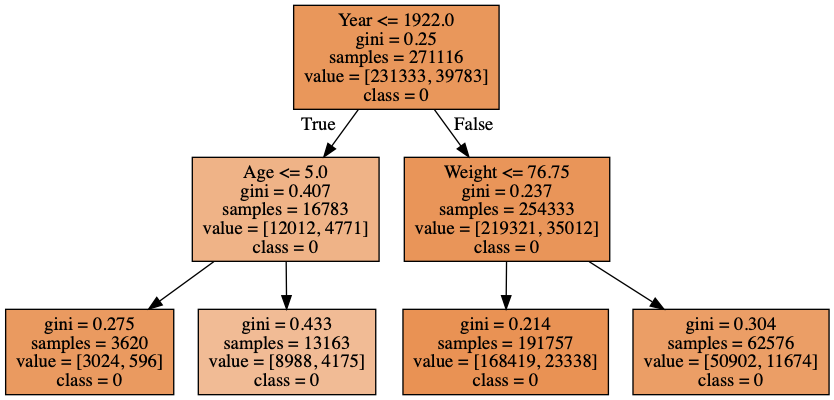

In [13]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### **Summary and Managerial Insights**

* **Summary**:  For those athletes who competed after 1922 and weigh over than 76.75 kg had a higher chance of winning a medal.

* **Insight**: Based on the analysis, athletes who competed after 1922 that weigh less than 76.75 kg have a 12% chance of winning a medal while those that weigh more than 76.75 kg have a 19% chance of winning a medal. Therefore, as a recruiter or potential Olympian, if you weigh more as an athlete, you have a greater chance of winning a medal.

### **Statistical Graph**

* Bin year and weight for visualization purposes.

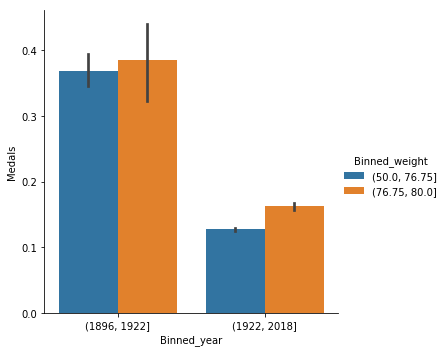

In [14]:
df2['Binned_year'] = pd.cut(df.Year,bins = [1896,1922,2018])
df2['Binned_weight'] = pd.cut(df.Weight,bins=[50,76.75,80])
sns.catplot(x='Binned_year',y='Medals',data=df2,kind='bar', hue='Binned_weight', aspect=1)

The right hand side of our graph shows that athletes who competed after 1922 and weigh more than 76.75kg has a slight advantage over the athletes who weighed less.

## 2. Find relationship between Table Tennis and medals
* Identify all sports
* Locate 'Table Tennis'
* Drop unnecessary columns

In [15]:
df.Sport.unique()

array(['Basketball', 'Judo', 'Football', 'Tug-Of-War', 'Speed Skating',
       'Cross Country Skiing', 'Athletics', 'Ice Hockey', 'Swimming',
       'Badminton', 'Sailing', 'Biathlon', 'Gymnastics',
       'Art Competitions', 'Alpine Skiing', 'Handball', 'Weightlifting',
       'Wrestling', 'Luge', 'Water Polo', 'Hockey', 'Rowing', 'Bobsleigh',
       'Fencing', 'Equestrianism', 'Shooting', 'Boxing', 'Taekwondo',
       'Cycling', 'Diving', 'Canoeing', 'Tennis', 'Modern Pentathlon',
       'Figure Skating', 'Golf', 'Softball', 'Archery', 'Volleyball',
       'Synchronized Swimming', 'Table Tennis', 'Nordic Combined',
       'Baseball', 'Rhythmic Gymnastics', 'Freestyle Skiing',
       'Rugby Sevens', 'Trampolining', 'Beach Volleyball', 'Triathlon',
       'Ski Jumping', 'Curling', 'Snowboarding', 'Rugby',
       'Short Track Speed Skating', 'Skeleton', 'Lacrosse', 'Polo',
       'Cricket', 'Racquets', 'Motorboating', 'Military Ski Patrol',
       'Croquet', 'Jeu De Paume', 'Roque', 'Al

In [16]:
pong = df.loc[df.Sport == 'Table Tennis']
pong.head(3)

,ID,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Season,Medals,Gender
498,277,Shaimaa Abdul Aziz,19.0,160.0,53.0,EGY,2000,Sydney,Table Tennis,Singles,1,0,1
499,277,Shaimaa Abdul Aziz,19.0,160.0,53.0,EGY,2000,Sydney,Table Tennis,Doubles,1,0,1
500,277,Shaimaa Abdul Aziz,27.0,160.0,53.0,EGY,2008,Beijing,Table Tennis,Singles,1,0,1


In [17]:
ping = pong.drop(columns=['ID','Name','NOC','City','Sport','Event'])
ping.head(3)

,Age,Height,Weight,Year,Season,Medals,Gender
498,19.0,160.0,53.0,2000,1,0,1
499,19.0,160.0,53.0,2000,1,0,1
500,27.0,160.0,53.0,2008,1,0,1


### Machine Learning - Classification Tree

In [18]:
X = ping.drop(columns = 'Medals')
Y = ping.Medals

In [19]:
dt = tree.DecisionTreeClassifier(max_depth = 3)

In [20]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

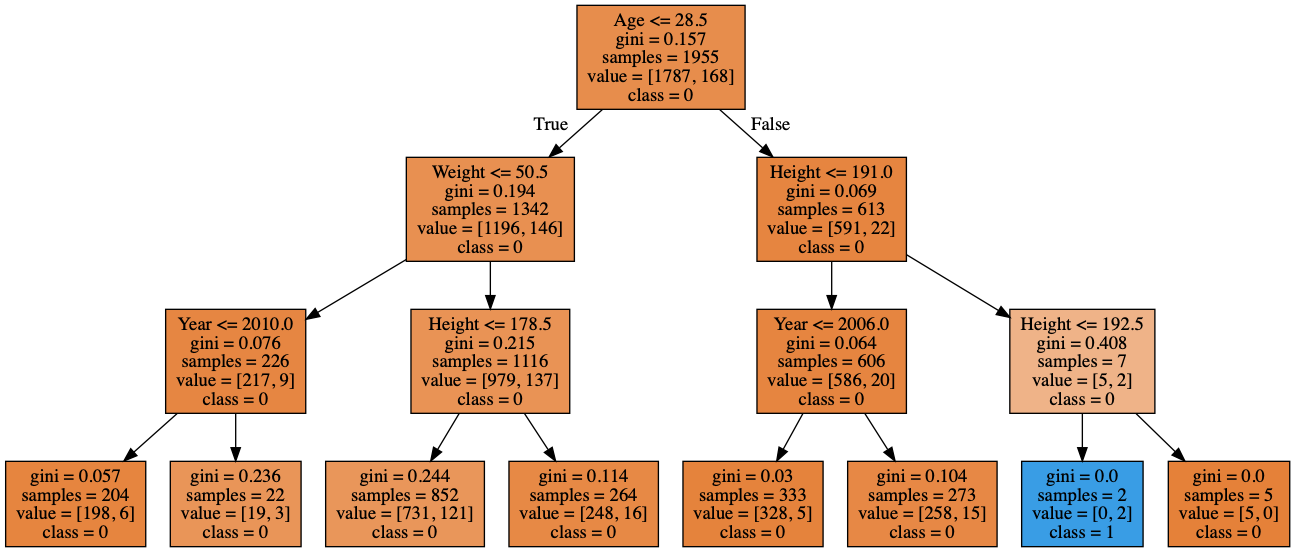

In [21]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### **Summary and Managerial Insights**

* **Summary**: Table tennis athletes who are under 28.5 years old, over 50.5kg and under 178.5cm are more likely to place on the podium.

* **Insight**: According to the finding from the decision tree, for those athletes under 28.5 years old that weigh under 50.5kg have 4% chance of winning, while those athletes above 50.5 kgs have a 12% chance of placing on the podium. Upon further analysis, for those athlete over 50.5kg and are under 178.5cm tall have a 14% chance of winning a medal, as opposed to those coming in over 178.5cm have just a 6% chance of earning a medal. As a trainer or Olympian, to increase the chance at winning a medal in table tennis, one should try to compete prior to turning 28.5 years old, weigh over 50.5kg and be under 178.5cm tall. 

#### **Statistical Graph**

* Chart showing weight compared to medals earned and distributed by age.

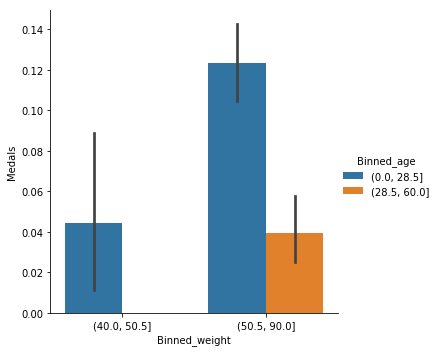

In [22]:
ping['Binned_weight'] = pd.cut(df.Weight,bins=[40,50.5,90])
ping['Binned_age'] = pd.cut(df.Age,bins=[0,28.5,60])
sns.catplot(x='Binned_weight',y='Medals',data=ping,kind='bar',hue = 'Binned_age',aspect=1)

The right side of the graph shows that those under 28.5 years old and over 50.5kg has an advantage at winning a medal compared to those that are older and lighter.

* Chart showing height compared to medals earned and distributed by age.

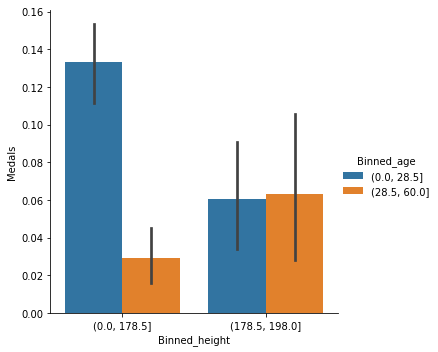

In [23]:
ping['Binned_height'] = pd.cut(df.Height,bins=[0,178.5,198])
ping['Binned_age'] = pd.cut(df.Age,bins=[0,28.5,60])
sns.catplot(x='Binned_height',y='Medals',data=ping,kind='bar',hue = 'Binned_age',aspect=1)

The left side of the graph shows that those who are under 28.5 years old and are shorter than 178.5cm have a significant advantage over those that are older and taller.

## 3. Find differences of outcomes during the Cold War and after the Cold War between the United States and Russia/Soviet Union.

* Rename the df
* Drop all data prior to the Cold War.

In [24]:
Compare = df[(df.Year >= 1947)]

#### Covert the 'Year' column to binary values. Binary column to decipher the Cold War years

* **Cold War** = 0 (1947 - 1991)
* **Post-Cold War** = 1

In [25]:
Compare['Binned_Year'] = Compare.Year.apply(lambda x:0 if x >= 1947 and x <= 1991 else 1)
Compare.head(3)

,ID,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Season,Medals,Gender,Binned_Year
0,1,A Dijiang,24.0,180.0,80.0,CHN,1992,Barcelona,Basketball,Basketball,1,0,0,1
1,2,A Lamusi,23.0,170.0,60.0,CHN,2012,London,Judo,Extra-Lightweight,1,0,0,1
4,5,Christine Jacoba Aaftink,21.0,185.0,82.0,NED,1988,Calgary,Speed Skating,500 metres,0,0,1,0


#### Create binary USA and Russia/Soviet column

* **USA** = 0
* **Russia/Soviet** = 1

In [26]:
Compare['USandRUS'] = Compare.NOC.apply(lambda x:0 if x == 'USA' else 1 if x == 'RUS' or x == 'URS' else 2)

#### Drop all countries that are not USA or RUS/URS

In [27]:
Compare = Compare.loc[Compare.USandRUS < 2]
Compare.head(3)

,ID,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Season,Medals,Gender,Binned_Year,USandRUS
10,6,Per Knut Aaland,31.0,188.0,75.0,USA,1992,Albertville,Cross Country Skiing,10 kilometres,0,0,0,1,0
11,6,Per Knut Aaland,31.0,188.0,75.0,USA,1992,Albertville,Cross Country Skiing,50 kilometres,0,0,0,1,0
12,6,Per Knut Aaland,31.0,188.0,75.0,USA,1992,Albertville,Cross Country Skiing,10/15 kilometres Pursuit,0,0,0,1,0


* Drop unnecessary columns

In [28]:
Compare = Compare.drop(columns = ['Year','ID','NOC','Season','Name','City','Sport','Event'])

In [29]:
Compare.head(3)

,Age,Height,Weight,Medals,Gender,Binned_Year,USandRUS
10,31.0,188.0,75.0,0,0,1,0
11,31.0,188.0,75.0,0,0,1,0
12,31.0,188.0,75.0,0,0,1,0


### Machine Learning - Classification Tree

* Identify if there were any relationships between other variables and medals won by the US or Russia.

In [30]:
X = Compare.drop(columns='Medals')

In [31]:
Y = Compare.Medals

In [32]:
dt = tree.DecisionTreeClassifier(max_depth = 2)

In [33]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

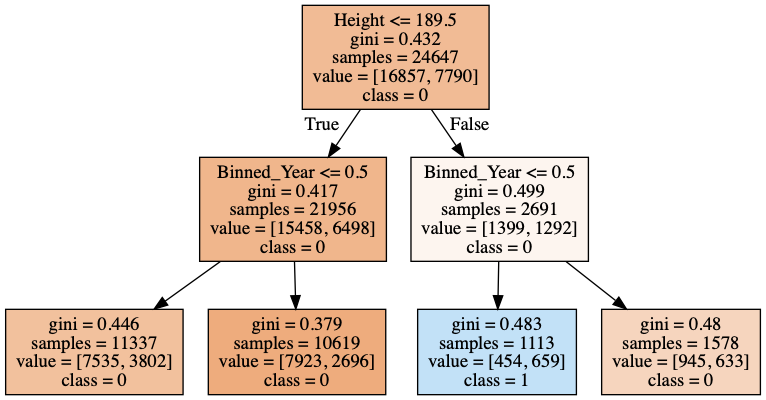

In [34]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

### **Finding**
This decision tree does not show us interesting information. So, we spilt the data into two dataframes and plotted them into a bar graph that compares the US and Russia during and after the war to find if weight is a factor in the amount of medals won. 

* Rename the dataframe for easier coding

In [35]:
df4 = Compare

### **Statistical Graph**

In [36]:
df4['Binned_Weight'] = pd.cut(df4.Weight,bins=[34,65,100,130,170])

* Convert cold war years into binary values

In [37]:
ColdWar = df4.loc[df4.Binned_Year == 0]

In [38]:
PostWar = df4.loc[df4.Binned_Year == 1]

#### During Cold War
* Chart showing weight compared to medals earned and distributed by weight between Russia and the US during the Cold War.

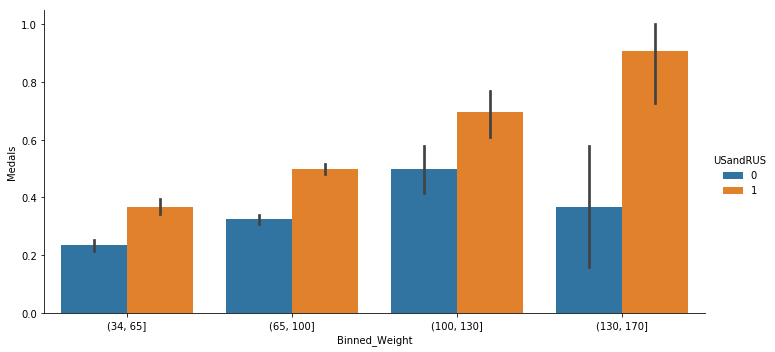

In [39]:
sns.catplot(x='Binned_Weight',y='Medals',data=ColdWar,kind='bar',hue = 'USandRUS',aspect=2)

#### After Cold War
* Chart showing weight compared medals earned and distributed by weight between Russia and the US after the Cold War.

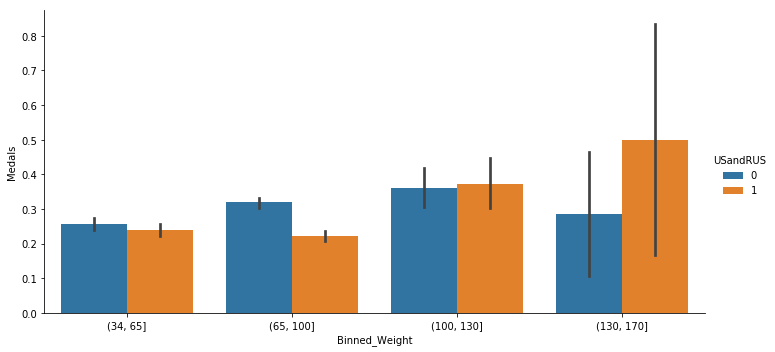

In [40]:
sns.catplot(x='Binned_Weight',y='Medals',data=PostWar,kind='bar',hue = 'USandRUS',aspect=2)

### **Finding**
The graphs show that among athletes, during the Cold War, the Soviet Union had many more medals than the US while also being a great deal heavier by average. The US after the Cold War edged out the Russians in lighter-weight events while the Russians continued to win in heavier weighted events. The Soviets emphasized events based on the size of the athletes, but during the Cold War they dominated their Cold War enemy.  

### **Machine Learning**
* Predict whether an American or Russian will win a medal based on our model.
* Binned year was binary while binned weight was a pandas variable. Since weight was still in the df, we removed the binned weight since the confusion matrix would not process with it.

In [41]:
Compare = Compare.drop(columns = 'Binned_Weight')
Compare.head(3)

,Age,Height,Weight,Medals,Gender,Binned_Year,USandRUS
10,31.0,188.0,75.0,0,0,1,0
11,31.0,188.0,75.0,0,0,1,0
12,31.0,188.0,75.0,0,0,1,0


### Prediction Analysis

* Split data into 70% training and 30% test

In [42]:
X = Compare.drop(columns = 'Medals')

In [43]:
Y = Compare.Medals

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,
                                                    random_state=2)

#### Training on the training set

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
cl = RandomForestClassifier(random_state=0)

In [48]:
cl.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Predict on training set

In [49]:
predictions_on_trainingset = cl.predict(X_train)

In [50]:
from sklearn.metrics import confusion_matrix

#### Training Set Confusion Matrix

In [51]:
confusion_matrix(Y_train, predictions_on_trainingset)

array([[11247,   579],
       [ 1196,  4230]])

#### Predict on test set

In [52]:
Y_pred = cl.predict(X_test)

In [53]:
Y_proba = cl.predict_proba(X_test)

#### Test Set Confusion Matrix

In [54]:
confusion_matrix(Y_test, Y_pred)

array([[4175,  856],
       [1440,  924]])

In [55]:
n = str(4175+856+1440+924)
print('The total number of samples is equal to ' + n)
predict_y = str(856+924)
predict_n = str(4175+1440)
print('The classifier predicted yes for ' + predict_y + ' cases')
print('The classifer predicted no for ' + predict_n + ' cases')
actual_y = str(1440 + 924)
actual_n = str(4175 + 856)
print('The actual yes was ' + actual_y + ' cases')
print('The actual no for ' + actual_n + ' cases')

The total number of samples is equal to 7395
The classifier predicted yes for 1780 cases
The classifer predicted no for 5615 cases
The actual yes was 2364 cases
The actual no for 5031 cases


#### **Additional Metrics**

* **Accuracy** : not the correct metric as our true positive and true negatives are unbalanced.

In [56]:
sk.metrics.accuracy_score(Y_test,Y_pred)

0.6895199459093982

* **Precision** : just 51% of the predicted positives were actually positive.

In [57]:
sk.metrics.precision_score(Y_test,Y_pred)

0.5191011235955056

* **Recall/True Positive Rate**: our model will predict a medalist 39% of the time.

In [58]:
sk.metrics.recall_score(Y_test,Y_pred)

0.39086294416243655

* **AUC Score**: shows that the prediciton is generally random.

In [59]:
sk.metrics.roc_auc_score(Y_test,Y_proba[:,1])

0.6707477514200451

#### **Cross-validation**

In [60]:
from sklearn.model_selection import KFold

In [61]:
kf = KFold(n_splits=10,random_state=0,shuffle=True)

In [62]:
aucs = sk.model_selection.cross_val_score(cl,X,Y,cv=kf,scoring='roc_auc')

In [63]:
aucs.mean()

0.6774848955875865

#### Highest performing classifer

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

clfs = [DecisionTreeClassifier(), sk.ensemble.RandomForestClassifier(n_jobs=-1), sk.naive_bayes.GaussianNB(),
        sk.linear_model.LogisticRegression(n_jobs=-1),sk.tree.DecisionTreeClassifier(),sk.ensemble.AdaBoostClassifier(),
        QuadraticDiscriminantAnalysis(),MLPClassifier(),SVC()]

In [65]:
maxAUC = -1
bestCL = ''
for cl in clfs:
    kf = KFold(n_splits=10,random_state=0,shuffle=True)
    aucs = sk.model_selection.cross_val_score(cl,X,Y,cv=kf,scoring='roc_auc')
    auc = aucs.mean()
    if auc > maxAUC:
        maxAUC = auc
        bestCL = cl

In [66]:
bestCL

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
maxAUC

0.6761806092482168

### **Summary and Managerial Insights**

* **Summary**: The random forest classifer will predict a medalist correctly from the US or Russia approximately 39% of the time.

* **Insight**: From our overall data, we find that there is a greater chance that an athlete weighing more will earn a medal. As an athlete is training it may be advantageous to compete at a slightly higher weight than their competition as it can give them a higher chance of winning a medal. Due to the low prediction rate, our prediction model is not the best indicator to use to predict a medalist from the US or Russia.

##### Additional proof for relationship between weight and medals

In [68]:
Compare[Compare.Weight > Compare.Weight.median()].groupby(['Medals','USandRUS']).Weight.mean()

Medals  USandRUS
0       0           83.664783
        1           82.495397
1       0           85.487467
        1           84.766751
Name: Weight, dtype: float64

In [69]:
Compare[Compare.Weight < Compare.Weight.median()].groupby(['Medals','USandRUS']).Weight.mean()

Medals  USandRUS
0       0           50.129908
        1           49.837820
1       0           52.012588
        1           48.611005
Name: Weight, dtype: float64

In general, medalists were heavier than non-medalist for US and Russian athletes.